# Source Localization for EEG data

Using LASSO regression on a real EEG dataset to determine the brain region that is active under an auditory stimulus.

We are using time-series data here. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). 

In [7]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

File eeg_dat.p is already downloaded


Now run the following command which will get the data from the `pickle` file.

In [8]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)

To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Each current comes from one brain region (called a *voxel*) in either the `x`, `y` or `z` direction.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

In [9]:
nchan, ncur = X.shape
nchan, nt = Y.shape
nvoxels = ncur // 3
print('Number times   = %d' % nt)
print('Number currents = %d' % ncur)
print('Number voxels = %d' % nvoxels)
print('Number channels = %d' % nchan)

Number times   = 85
Number currents = 22494
Number voxels = 7498
Number channels = 305


## Ridge Regression

Estimate the currents in the brain from the measurements `Y`.  One simple linear model is:

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

*  There are `nt x ncur` unknowns in `W`
*  There are only `nt x nchan` measurements in `Y`.

In this case, we have:

    number of measurements  << number of unknowns
    
We need to use regularization in these circumstances.

In [10]:
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.33)

In [11]:
regr = Ridge(alpha=1)
regr.fit(Xtr,Ytr)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [12]:
Yhat = regr.predict(Xtr)
rsq_tr = r2_score(Ytr, Yhat)
print('R^2 training = %7.4f' % rsq_tr)


Yhat = regr.predict(Xts)
rsq_ts = r2_score(Yts, Yhat)
print('R^2 test     = %7.4f' % rsq_ts)

R^2 training =  0.6120
R^2 test     =  0.1264


We can see that `R^2` value is large for the training data, it is very low for the test data.  This suggest that even with regularization, **the model is over-fitting the data**.

Different `R^2` score using different values of `alpha`.  

Use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}`

In [13]:
alphas = np.logspace(-2,2,20)
rsq = []

for a in alphas:
    regr = Ridge(alpha=a)
    regr.fit(Xtr,Ytr)
    
    Yhat = regr.predict(Xts)
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    print('alpha=%12.4e rsq=%7.4f' % (a,rsqi))

alpha=  1.0000e-02 rsq=-0.2913
alpha=  1.6238e-02 rsq=-0.1926
alpha=  2.6367e-02 rsq=-0.1064
alpha=  4.2813e-02 rsq=-0.0330
alpha=  6.9519e-02 rsq= 0.0271
alpha=  1.1288e-01 rsq= 0.0740
alpha=  1.8330e-01 rsq= 0.1076
alpha=  2.9764e-01 rsq= 0.1277
alpha=  4.8329e-01 rsq= 0.1349
alpha=  7.8476e-01 rsq= 0.1313
alpha=  1.2743e+00 rsq= 0.1199
alpha=  2.0691e+00 rsq= 0.1038
alpha=  3.3598e+00 rsq= 0.0858
alpha=  5.4556e+00 rsq= 0.0678
alpha=  8.8587e+00 rsq= 0.0510
alpha=  1.4384e+01 rsq= 0.0363
alpha=  2.3357e+01 rsq= 0.0241
alpha=  3.7927e+01 rsq= 0.0147
alpha=  6.1585e+01 rsq= 0.0079
alpha=  1.0000e+02 rsq= 0.0032


Optimal R^2 =  0.1349


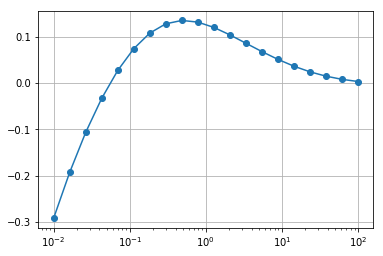

In [14]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal R^2 = %7.4f' % rsq_opt)

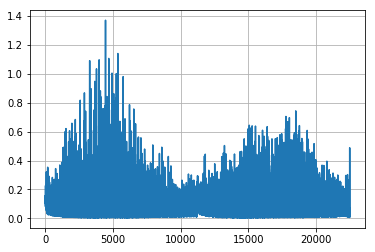

In [15]:
im = np.argmax(rsq)
aopt = alphas[im]

regr = Ridge(alpha=aopt)
regr.fit(Xtr,Ytr)

W = regr.coef_.T
Wrms = np.sqrt(np.sum(W**2, axis=1))

plt.plot(Wrms)
plt.grid()

We can see that the vector `Wrms` is not sparse, that is the solution that is found with Ridge regression finds currents in all locations.

## LASSO Regression

We can improve the estimate by imposing sparsity and can impose this constraint using LASSO regularization.

In [16]:
regr = Lasso(alpha = 1e-3,max_iter=100,tol=0.01)
regr.fit(Xtr,Ytr)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.01, warm_start=False)

In [17]:
Yhat = regr.predict(Xts)
rsq = r2_score(Yts, Yhat)
print(rsq)

0.16861994512453912


Which is a much better fit than with the Ridge regression solution.  

We can now search for the optimal `alpha` using cross-validation.

In [18]:
alphas = np.logspace(-4,-3,5)
rsq = []
Ws = []

for a in alphas:
    
    regr = Lasso(alpha =a, max_iter=100, tol=0.01)
    regr.fit(Xtr,Ytr)
    
    Yhat = regr.predict(Xts)
    
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    Ws.append(regr.coef_.T)
    
    print('alpha = %12.4e rsq=%7.4f' % (a, rsqi))

alpha =   1.0000e-04 rsq= 0.2493
alpha =   1.7783e-04 rsq= 0.2983
alpha =   3.1623e-04 rsq= 0.2944
alpha =   5.6234e-04 rsq= 0.2525
alpha =   1.0000e-03 rsq= 0.1686


Optimal test R^2 =  0.2983


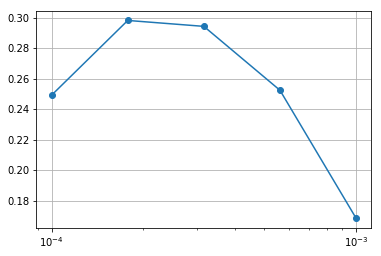

In [19]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal test R^2 = %7.4f' % rsq_opt)

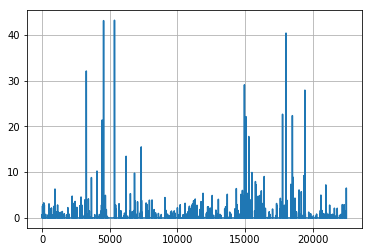

In [20]:
iopt = np.argmax(rsq)
Wopt = Ws[iopt]
Wrms = np.sqrt(np.sum(Wopt**2, axis=1))

plt.plot(Wrms)
plt.grid()

As we can see, the current matrix `W` for the optimal `alpha` is much sparser!